In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

Using TensorFlow backend.
/home/omid/.conda/envs/iot_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [3]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, includeDirection = False , TrimAt= 15 ):
    if includeDirection:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [4]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [5]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y, ret_y_s

In [6]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = {}
y_train = {}

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    with open(  '../files/finalTrainingSets/segmentation_rbf_1/merged_with_rbf_1_hub.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/finalTrainingSets/segmentation_rbf_1/merged_with_rbf_1_pcap.json'  ) as f:
        x_data = json.load(f)
        
#     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
#         y_data = json.load(f)

#     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
#         x_data = json.load(f)
  
    if len( y_data ) != len(x_data) :
        print( pick )
        
    
    x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , Mapping=Mapper )
    
    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    test_files = sorted(glob.glob( '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' ))
    print( "found files : " , len(test_files) )
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/', fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join('../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/', fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)


        x_test.append(t_x)
        y_test.append(t_y)
        y_test_service.append(t_z)
            
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
25849 25574
loading from test files
found files :  4
32069 32069
19968 19968
9109 9109
6404 6404


(25574, 4)

In [8]:
len(y_data)

26889

In [9]:
list(np.unique(  np.concatenate( y_train  )))

['acceleration',
 'activity',
 'battery',
 'button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'ping',
 'status',
 'switch',
 'temperature',
 'threeAxis',
 'unknown',
 'water']

In [7]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'), (1, 'activity'), (2, 'battery'), (3, 'button'), (4, 'colorTemperature'), (5, 'contact'), (6, 'level'), (7, 'lock'), (8, 'motion'), (9, 'no_logs'), (10, 'ping'), (11, 'status'), (12, 'switch'), (13, 'temperature'), (14, 'threeAxis'), (15, 'unknown'), (16, 'water')]


[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'no_logs'),
 (10, 'ping'),
 (11, 'status'),
 (12, 'switch'),
 (13, 'temperature'),
 (14, 'threeAxis'),
 (15, 'unknown'),
 (16, 'water')]

In [ ]:
[ (i , classes[i]) for i in range( len(classes) ) ]

In [ ]:
def is_clean_event( inp, return_clean= True  ):
    if return_clean:
        return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
    else:
        return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
    
def is_clean_service( inp, return_clean= True  ):
    
    if return_clean:
        return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
    else:
        return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 
#     return  "contact-open" not in inp and 'contact-closed' not in inp

In [ ]:

y_test[0][0]

In [ ]:
toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
x_train= [ x_train[i] for i in toKeep ]
y_train= [ y_train[i] for i in toKeep ]


In [ ]:
for j in range(len(x_test)):
    toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
    y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [ ]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')



service_classes= ["","",""]


In [8]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None, twoD= False ):
#  y data 
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [9]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):

def fix_unknwons( records , unknown_index  ):

    law  = np.ones( len( records[0] ) )
    law[unknown_index]=0
    
    records = records* law
    
    for x in records:
        if np.sum(x)==0 :
            x[unknown_index]=1
    
    return records 

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5 ):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
    
    pred = fix_unknwons(pred, classes.index('unknown'))
    y_test = fix_unknwons(y_test, classes.index('unknown'))
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %16s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %d/%d/%d/%d"  %
             (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn ))
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %d/%d/%d/%d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    

In [10]:
def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp[inp>=conffidance] = 1
    inp[inp<conffidance] = 0
        
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.7):
    pred_temp = model.predict(data)
    print_info(gt, pred_temp, classes , confidance=confidance)
    print( len(classes ), len( pred_temp[0] ) )
    xcc= make_readable_results(pred_temp , classes)
    y_gt = make_readable_results( gt, classes )
    temp_dic = {} 
    for pick in range(len(xcc)): 
        temp_dic[ pick +1 ] =  { 'seq': str(data[pick]),
                               'pred': xcc[pick],
                                'true':y_gt[pick]
                               }   

    with open(path , 'w') as f:
        json.dump(temp_dic , f, indent=4)


# def makeReadable( model , data, gt, path , classes, confidance=0.7, x):
#     pred_temp = model.predict( data)
#     print_info(gt, pred_temp, classes , confidance=confidance)
#     xcc= make_readable_results( pred_temp , classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] = xcc[pick]  

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)

# Create the Model 

# Calcualte per class accuracy

# Random Forest baseline calc

In [57]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
# x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test[0], y_test[0] , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes) for i in range(len(x_test)) ] 
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [58]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_random_forest_train, y_random_forest_train)




# print(clf.feature_importances_)

# print(clf.predict([[0, 0, 0, 0]]))
# from sklearn import metrics
# scores = cross_val_score(clf, x_random_forest_train, y_random_forest_train, cv=10, scoring='accuracy')

In [59]:
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_tests[i][0])
    print_info( rf_tests[i][1], rf_pred, classes)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.999      0.167     0.059     0.087         6 1/32047/16/5
                      activity     0.998      0.042     0.400     0.075        48 2/32018/3/46
                       battery     0.999        nan     0.000     0.000         0 0/32042/27/0
                        button     1.000      0.143     0.143     0.143         7 1/32056/6/6
              colorTemperature     1.000        nan     0.000     0.000         0 0/32068/1/0
                       contact     0.993      0.654     0.206     0.313        78 51/31794/197/27
                         level     0.995      0.481     0.076     0.131        27 13/31883/159/14
                          lock     0.999      0.500     0.175     0.259        14 7/32022/33/7
                        motion     0.952      0.405     0.336   

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.158     0.391     0.225        57 9/19897/14/48
                      activity     0.999      0.053     0.500     0.095        19 1/19948/1/18
                       battery     0.999      0.000     0.000     0.000         7 0/19948/13/7
                        button     0.999      0.143     0.667     0.235        14 2/19953/1/12
              colorTemperature     1.000      0.667     1.000     0.800         6 4/19962/0/2
                       contact     0.992      0.699     0.530     0.603       176 123/19683/109/53
                         level     0.986      0.667     0.061     0.111        27 18/19663/278/9
                          lock     0.999      0.914     0.571     0.703        35 32/19909/24/3
                        motion     0.972      0.501     0.336

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.160     0.364     0.222        25 4/9077/7/21
                      activity     0.998      0.000     0.000     0.000        21 0/9087/1/21
                       battery     0.999      0.000     0.000     0.000         4 0/9099/6/4
                        button     1.000      0.000     0.000     0.000         3 0/9105/1/3
              colorTemperature     1.000        nan       nan       nan         0 0/9109/0/0
                       contact     0.992      0.679     0.510     0.582        78 53/8980/51/25
                         level     0.986      0.750     0.066     0.122        12 9/8970/127/3
                          lock     0.998      0.727     0.640     0.681        22 16/9078/9/6
                        motion     0.970      0.445     0.390     0.415     

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [60]:
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.89,data=rf_tests[i][0],gt=rf_tests[i][1],model=clf,path="rf_rbf1_"+test_names[i],x=rf_tests[i][0])
    

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.999      0.167     0.059     0.087         6 1/32047/16/5
                      activity     0.998      0.042     0.400     0.075        48 2/32018/3/46
                       battery     0.999        nan     0.000     0.000         0 0/32042/27/0
                        button     1.000      0.143     0.143     0.143         7 1/32056/6/6
              colorTemperature     1.000        nan     0.000     0.000         0 0/32068/1/0
                       contact     0.993      0.654     0.206     0.313        78 51/31794/197/27
                         level     0.995      0.481     0.076     0.131        27 13/31883/159/14
                          lock     0.999      0.500     0.175     0.259        14 7/32022/33/7
                        motion     0.952      0.405     0.336   

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.158     0.391     0.225        57 9/19897/14/48
                      activity     0.999      0.053     0.500     0.095        19 1/19948/1/18
                       battery     0.999      0.000     0.000     0.000         7 0/19948/13/7
                        button     0.999      0.143     0.667     0.235        14 2/19953/1/12
              colorTemperature     1.000      0.667     1.000     0.800         6 4/19962/0/2
                       contact     0.992      0.699     0.530     0.603       176 123/19683/109/53
                         level     0.986      0.667     0.061     0.111        27 18/19663/278/9
                          lock     0.999      0.914     0.571     0.703        35 32/19909/24/3
                        motion     0.972      0.501     0.336

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.160     0.364     0.222        25 4/9077/7/21
                      activity     0.998      0.000     0.000     0.000        21 0/9087/1/21
                       battery     0.999      0.000     0.000     0.000         4 0/9099/6/4
                        button     1.000      0.000     0.000     0.000         3 0/9105/1/3
              colorTemperature     1.000        nan       nan       nan         0 0/9109/0/0
                       contact     0.992      0.679     0.510     0.582        78 53/8980/51/25
                         level     0.986      0.750     0.066     0.122        12 9/8970/127/3
                          lock     0.998      0.727     0.640     0.681        22 16/9078/9/6
                        motion     0.970      0.445     0.390     0.415     

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.994      0.225     0.643     0.333        40 9/6359/5/31
                      activity     1.000        nan       nan       nan         0 0/6404/0/0
                       battery     0.999      0.000     0.000     0.000         2 0/6400/2/2
                        button     0.991      0.033     1.000     0.065        60 2/6344/0/58
              colorTemperature     1.000      0.000       nan     0.000         2 0/6402/0/2
                       contact     0.989      0.697     0.871     0.775       175 122/6211/18/53
                         level     0.994      0.515     0.791     0.624        66 34/6329/9/32
                          lock     0.999        nan     0.000     0.000         0 0/6399/5/0
                        motion     0.960      0.614     0.305     0.407     

In [ ]:
# makeReadable( data=rf_tests[0][0], model=clf, classes=classes, confidance=0.7,gt=rf_tests[0][1], path='sk_home_out.json' )

In [ ]:
# print_info(y_random_forest_test, rf_pred, classes)

In [ ]:
# print_info(y_random_forest_test, rf_pred, classes)

In [ ]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [ ]:
# cnts  = np.unique(np.array([ len(x) for x  in x_train ]), return_counts=True)
# # np.sort( cnts[1] )
# cnts

In [ ]:
test_names

In [11]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=False, classes=service_classes) for i in range(len(x_test)) ] 



In [32]:
x_lstm_prossed_train[0]

array([290,  99, 411,  99, 290,  99, 411,  99, 290,  99, 411,  99,   0,
         0,   0])

In [33]:
for i in range( len(lstm_tests) ):
    print( len( lstm_tests[i][0] ), len( lstm_tests_services[i][0] ) )

32069 32069
19968 19968
9109 9109
6404 6404


In [12]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests) ):
    lstm_tests[tt]= (lstm_tests[tt][0].reshape(len(lstm_tests[tt][0]),dim_size,1) , lstm_tests[tt][1],lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [35]:
np.sum(y_s_lstm_processed_train)

24553.0

In [13]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) **2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
bi_d_1 =Dropout(0.1)(bi_d_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_1 = Dropout(0.1)(lstm_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)

lstm_4 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True  )(inputs)
# lstm_4 = Flatten()(lstm_4)
# lstm_4 =Dense(128, activation='relu')  (lstm_4)
lstm_4 = Dropout(0.1)(lstm_4)
td_1= TimeDistributed(Dense(256, activation='relu'))(lstm_2)
out = Conv1D(128,3,padding='same')(td_1)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
lstmFirst  = Conv1D(128,3,padding='same')(out)
lstmFirst = Flatten()(lstmFirst)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
bi_d_raw_1 = Dropout(0.1)(bi_d_raw_1)
lstm_raw_1 =Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_1 = Dropout(0.1)(lstm_raw_1)
lstm_raw_2 =Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)


out = Conv1D(128,3,padding='same')(inputs)
out = Dropout(0.1)(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.1)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = Dropout(0.1)(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.1)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = Dropout(0.1)(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.1)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3,lstmFirst] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_1 = Dropout(0.1)(dens_out_1)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_2 = Dropout(0.1)(dens_out_2)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)
dens_out_3 = Dropout(0.1)(dens_out_3 )

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dropout( 0.1)(toService_1)
toService_1 = Dense( 130, name="to_service2" )(toService_1)
toService_1 = Dropout( 0.1)(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)


model2 = Model(inputs=[inputs], outputs=[service_output])


losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 

model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('LSTM_without_Home', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 15, 1)         0                                            
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 15, 128)       512         input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 15, 128)       512         input_1[0][0]                    
____________________________________________________________________________________________________
dropout_12 (Dropout)             (None, 15, 128)       0           conv1d_5[0][0]                   
___________________________________________________________________________________________

Epoch 1/100
25574/25574 [==============================] - 7s - loss: 57.3557 - f1_perRow: 0.0936 - f1_perClass: 0.1418 - acc: 0.3065     
Epoch 2/100
25574/25574 [==============================] - 1s - loss: 43.0267 - f1_perRow: 0.1282 - f1_perClass: 0.3002 - acc: 0.5160     
Epoch 3/100
25574/25574 [==============================] - 1s - loss: 34.2817 - f1_perRow: 0.1642 - f1_perClass: 0.4329 - acc: 0.5024     
Epoch 4/100
25574/25574 [==============================] - 1s - loss: 30.8950 - f1_perRow: 0.1924 - f1_perClass: 0.5485 - acc: 0.5023     
Epoch 5/100
25574/25574 [==============================] - 2s - loss: 28.3672 - f1_perRow: 0.1969 - f1_perClass: 0.5452 - acc: 0.5052     
Epoch 6/100
25574/25574 [==============================] - 1s - loss: 26.9914 - f1_perRow: 0.2253 - f1_perClass: 0.5872 - acc: 0.5062     
Epoch 7/100
25574/25574 [==============================] - 2s - loss: 25.6117 - f1_perRow: 0.2337 - f1_perClass: 0.6048 - acc: 0.5102     
Epoch 8/100
25574/25574 [==

In [139]:
# losses = {
# #     "service_output": f1_loss_perClass ,
#     "service_output": f1_loss_perClass ,
# #     "service_output": "categorical_crossentropy",
# }
# lossWeights = {#"service_output": 20,
#                "service_output": 30.0 ,
# #     "service_output": 20
# }
 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
#     "service_output":weighted_categorical_crossentropy(weights),
    "service_output":"categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 10.0 ,
    "service_output": 8}
 

model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [140]:
model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(   ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=13500, shuffle=True, callbacks=callbacks_list)


Epoch 1/300
25574/25574 [==============================] - 7s - loss: 9.9583 - f1_perRow: 0.4208 - f1_perClass: 0.6876 - acc: 0.6850      
Epoch 2/300
25574/25574 [==============================] - 1s - loss: 7.4962 - f1_perRow: 0.3964 - f1_perClass: 0.6648 - acc: 0.7019     
Epoch 3/300
25574/25574 [==============================] - 1s - loss: 6.1992 - f1_perRow: 0.4058 - f1_perClass: 0.6885 - acc: 0.7592     
Epoch 4/300
25574/25574 [==============================] - 1s - loss: 5.4206 - f1_perRow: 0.4491 - f1_perClass: 0.7366 - acc: 0.7909     
Epoch 5/300
25574/25574 [==============================] - 1s - loss: 5.0470 - f1_perRow: 0.4968 - f1_perClass: 0.7709 - acc: 0.8174     
Epoch 6/300
25574/25574 [==============================] - 1s - loss: 4.8176 - f1_perRow: 0.5250 - f1_perClass: 0.7872 - acc: 0.8217     
Epoch 7/300
25574/25574 [==============================] - 1s - loss: 4.6387 - f1_perRow: 0.5530 - f1_perClass: 0.7963 - acc: 0.8312     
Epoch 8/300
25574/25574 [========

25574/25574 [==============================] - 1s - loss: 3.9958 - f1_perRow: 0.6440 - f1_perClass: 0.8360 - acc: 0.8527     
Epoch 61/300
25574/25574 [==============================] - 1s - loss: 3.9931 - f1_perRow: 0.6404 - f1_perClass: 0.8365 - acc: 0.8532     
Epoch 62/300
25574/25574 [==============================] - 1s - loss: 3.9905 - f1_perRow: 0.6506 - f1_perClass: 0.8366 - acc: 0.8537     
Epoch 63/300
25574/25574 [==============================] - 1s - loss: 3.9687 - f1_perRow: 0.6488 - f1_perClass: 0.8377 - acc: 0.8543     
Epoch 64/300
25574/25574 [==============================] - 1s - loss: 3.9854 - f1_perRow: 0.6488 - f1_perClass: 0.8360 - acc: 0.8528     
Epoch 65/300
25574/25574 [==============================] - 1s - loss: 3.9763 - f1_perRow: 0.6457 - f1_perClass: 0.8387 - acc: 0.8527     
Epoch 66/300
25574/25574 [==============================] - 1s - loss: 3.9606 - f1_perRow: 0.6475 - f1_perClass: 0.8359 - acc: 0.8533     
Epoch 67/300
25574/25574 [==============

25574/25574 [==============================] - 1s - loss: 3.9432 - f1_perRow: 0.6457 - f1_perClass: 0.8381 - acc: 0.8577     
Epoch 177/300
25574/25574 [==============================] - 1s - loss: 3.9505 - f1_perRow: 0.6462 - f1_perClass: 0.8381 - acc: 0.8562     
Epoch 178/300
25574/25574 [==============================] - 1s - loss: 3.9453 - f1_perRow: 0.6517 - f1_perClass: 0.8388 - acc: 0.8574     
Epoch 179/300
25574/25574 [==============================] - 1s - loss: 3.9473 - f1_perRow: 0.6497 - f1_perClass: 0.8378 - acc: 0.8583     
Epoch 180/300
25574/25574 [==============================] - 1s - loss: 4.1648 - f1_perRow: 0.6281 - f1_perClass: 0.8300 - acc: 0.8476     
Epoch 181/300
25574/25574 [==============================] - 1s - loss: 3.9717 - f1_perRow: 0.6499 - f1_perClass: 0.8361 - acc: 0.8563     
Epoch 182/300
25574/25574 [==============================] - 1s - loss: 4.0759 - f1_perRow: 0.6396 - f1_perClass: 0.8328 - acc: 0.8524     
Epoch 183/300
25574/25574 [=======

25574/25574 [==============================] - 1s - loss: 3.9366 - f1_perRow: 0.6585 - f1_perClass: 0.8400 - acc: 0.8475     
Epoch 293/300
25574/25574 [==============================] - 1s - loss: 3.9376 - f1_perRow: 0.6504 - f1_perClass: 0.8403 - acc: 0.8485     
Epoch 294/300
25574/25574 [==============================] - 1s - loss: 4.0638 - f1_perRow: 0.6370 - f1_perClass: 0.8334 - acc: 0.8444     
Epoch 295/300
25574/25574 [==============================] - 1s - loss: 4.0816 - f1_perRow: 0.6371 - f1_perClass: 0.8325 - acc: 0.8472     
Epoch 296/300
25574/25574 [==============================] - 1s - loss: 4.0906 - f1_perRow: 0.6345 - f1_perClass: 0.8320 - acc: 0.8450     
Epoch 297/300
25574/25574 [==============================] - 1s - loss: 4.1079 - f1_perRow: 0.6304 - f1_perClass: 0.8330 - acc: 0.8457     
Epoch 298/300
25574/25574 [==============================] - 1s - loss: 4.0405 - f1_perRow: 0.6418 - f1_perClass: 0.8322 - acc: 0.8470     
Epoch 299/300
25574/25574 [=======

In [108]:
model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam( ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=13500, shuffle=True, callbacks=callbacks_list)


Epoch 1/300
25574/25574 [==============================] - 5s - loss: 4.1338 - f1_perRow: 0.6610 - f1_perClass: 0.8622 - acc: 0.8425     
Epoch 2/300
25574/25574 [==============================] - 1s - loss: 4.0969 - f1_perRow: 0.6447 - f1_perClass: 0.8634 - acc: 0.8523     
Epoch 3/300
25574/25574 [==============================] - 1s - loss: 4.1391 - f1_perRow: 0.6231 - f1_perClass: 0.8620 - acc: 0.8506     
Epoch 4/300
25574/25574 [==============================] - 1s - loss: 4.1152 - f1_perRow: 0.6154 - f1_perClass: 0.8628 - acc: 0.8475     
Epoch 5/300
25574/25574 [==============================] - 1s - loss: 3.9190 - f1_perRow: 0.6431 - f1_perClass: 0.8694 - acc: 0.8511     
Epoch 6/300
25574/25574 [==============================] - 1s - loss: 4.0516 - f1_perRow: 0.6260 - f1_perClass: 0.8649 - acc: 0.8463     
Epoch 7/300
25574/25574 [==============================] - 1s - loss: 4.0704 - f1_perRow: 0.6108 - f1_perClass: 0.8643 - acc: 0.8450     
Epoch 8/300
25574/25574 [=========

25574/25574 [==============================] - 1s - loss: 3.7345 - f1_perRow: 0.6415 - f1_perClass: 0.8755 - acc: 0.8581     
Epoch 61/300
25574/25574 [==============================] - 1s - loss: 3.7342 - f1_perRow: 0.6473 - f1_perClass: 0.8755 - acc: 0.8576     
Epoch 62/300
25574/25574 [==============================] - 1s - loss: 3.7211 - f1_perRow: 0.6387 - f1_perClass: 0.8760 - acc: 0.8578     
Epoch 63/300
25574/25574 [==============================] - 1s - loss: 3.7012 - f1_perRow: 0.6493 - f1_perClass: 0.8766 - acc: 0.8578     
Epoch 64/300
25574/25574 [==============================] - 1s - loss: 3.6963 - f1_perRow: 0.6613 - f1_perClass: 0.8768 - acc: 0.8588     
Epoch 65/300
25574/25574 [==============================] - 1s - loss: 3.7377 - f1_perRow: 0.6603 - f1_perClass: 0.8754 - acc: 0.8577     
Epoch 66/300
25574/25574 [==============================] - 1s - loss: 3.7401 - f1_perRow: 0.6478 - f1_perClass: 0.8753 - acc: 0.8572     
Epoch 67/300
25574/25574 [==============

25574/25574 [==============================] - 1s - loss: 3.8636 - f1_perRow: 0.6376 - f1_perClass: 0.8712 - acc: 0.8538     
Epoch 177/300
25574/25574 [==============================] - 1s - loss: 3.8394 - f1_perRow: 0.6503 - f1_perClass: 0.8720 - acc: 0.8547     
Epoch 178/300
25574/25574 [==============================] - 1s - loss: 3.8368 - f1_perRow: 0.6664 - f1_perClass: 0.8721 - acc: 0.8535     
Epoch 179/300
25574/25574 [==============================] - 1s - loss: 3.8541 - f1_perRow: 0.6426 - f1_perClass: 0.8715 - acc: 0.8542     
Epoch 180/300
25574/25574 [==============================] - 1s - loss: 3.8479 - f1_perRow: 0.6570 - f1_perClass: 0.8717 - acc: 0.8539     
Epoch 181/300
25574/25574 [==============================] - 1s - loss: 3.8297 - f1_perRow: 0.6592 - f1_perClass: 0.8723 - acc: 0.8556     
Epoch 182/300
25574/25574 [==============================] - 1s - loss: 3.8431 - f1_perRow: 0.6530 - f1_perClass: 0.8719 - acc: 0.8553     
Epoch 183/300
25574/25574 [=======

25574/25574 [==============================] - 1s - loss: 3.8651 - f1_perRow: 0.6606 - f1_perClass: 0.8712 - acc: 0.8557     
Epoch 293/300
25574/25574 [==============================] - 1s - loss: 3.8657 - f1_perRow: 0.6741 - f1_perClass: 0.8711 - acc: 0.8560     
Epoch 294/300
25574/25574 [==============================] - 1s - loss: 3.8724 - f1_perRow: 0.6685 - f1_perClass: 0.8709 - acc: 0.8553     
Epoch 295/300
25574/25574 [==============================] - 1s - loss: 3.8388 - f1_perRow: 0.6669 - f1_perClass: 0.8720 - acc: 0.8563     
Epoch 296/300
25574/25574 [==============================] - 1s - loss: 3.8682 - f1_perRow: 0.6717 - f1_perClass: 0.8711 - acc: 0.8546     
Epoch 297/300
25574/25574 [==============================] - 1s - loss: 3.8444 - f1_perRow: 0.6755 - f1_perClass: 0.8719 - acc: 0.8549     
Epoch 298/300
25574/25574 [==============================] - 1s - loss: 3.9670 - f1_perRow: 0.6569 - f1_perClass: 0.8678 - acc: 0.8503     
Epoch 299/300
25574/25574 [=======

In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [84]:
model2.save( "LSTM-sigmoid-Raunak_1_alotofdropouts" )

In [ ]:
model2 = mode( "LSTM-sigmoid-Raunak_1_alotofdropouts" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [149]:
from keras.models import load_model
model2=load_model( "LSTM-sigmoid-Raunak_1_alotofdropouts"  ,
           custom_objects={ 'f1_perRow': f1_perRow ,'f1_perClass':f1_perClass})

In [38]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.89,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path="trained_with_home_"+test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    

==================HOME Case : home_muhammed_final.json =============


KeyboardInterrupt: 

In [61]:
classes.index('unknown')

14

In [70]:
law  = np.ones( len(classes) )
law[14] = 0 
# pred_2 = lstm_pred * law

pred_2 = fix_unknwons(lstm_pred, 14)
for i in range( 20 ):
    print( pred_2 [i], lstm_pred[i] , lstm_tests[1][1][i] )

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.] [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.] [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] 

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [69]:
lstm_pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [75]:
make_readable_results( lstm_tests[1][1], classes )[:25]

[['temperature'],
 ['contact', 'motion', 'status', 'temperature'],
 ['ping'],
 ['ping'],
 ['unknown'],
 ['ping'],
 ['unknown'],
 ['ping'],
 ['temperature'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['ping'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['ping'],
 ['ping', 'unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown']]

In [1]:
make_readable_results(  fix_unknwons(  lstm_pred  , 14 ), classes )[:25]

NameError: name 'make_readable_results' is not defined

In [141]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [146]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.992  )

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.998      0.298     0.810     0.436        57 17/19907/4/40
                      activity     1.000      0.632     0.857     0.727        19 12/19947/2/7
                       battery     0.999      0.000     0.000     0.000         7 0/19947/14/7
                        button     0.888      0.714     0.004     0.009        14 10/17729/2225/4
              colorTemperature     1.000      0.667     0.800     0.727         6 4/19961/1/2
                       contact     0.993      0.352     0.738     0.477       176 62/19770/22/114
                         level     0.999      0.185     0.714     0.294        27 5/19939/2/22
                          lock     0.998      0.914     0.438     0.593        35 32/19892/41/3
                        motion     0.981      0.003     0.077

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
# for i in ([1,2]) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.95
              )

In [22]:
# for i in [1] :
for i in range(len(lstm_tests)) :
# for i in ([1,2]) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000      0.167     0.083     0.111         6 1/32052/11/5
                      activity     0.999      0.417     0.833     0.556        48 20/32017/4/28
                       battery     0.993        nan     0.000     0.000         0 0/31836/233/0
                        button     0.994      0.571     0.020     0.039         7 4/31869/193/3
              colorTemperature     0.994        nan     0.000     0.000         0 0/31869/200/0
                       contact     0.985      0.641     0.101     0.175        78 50/31546/445/28
                         level     0.593      0.630     0.001     0.003        27 17/19014/13028/10
                          lock     0.996      0.500     0.051     0.093        14 7/31925/130/7
                        motion     0.948      0.138    

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [25]:
# for i in [1] :
# for i in range(len(lstm_tests)) :
for i in ([1,2]) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)   

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count      TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.351     0.476     0.404        57 20/19889/22/37
                      activity     0.999      0.632     0.800     0.706        19 12/19946/3/7
                       battery     0.992      0.000     0.000     0.000         7 0/19815/146/7
                        button     0.999      0.357     0.625     0.455        14 5/19951/3/9
              colorTemperature     1.000      0.667     0.571     0.615         6 4/19959/3/2
                       contact     0.984      0.676     0.317     0.432       176 119/19536/256/57
                         level     0.563      0.667     0.002     0.004        27 18/11224/8717/9
                          lock     0.995      0.771     0.221     0.344        35 27/19838/95/8
                        motion     0.961      0.119     0.0

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [105]:
model2.save( "LSTM_46F1_trainedWith_Home" )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [81]:
def calculate_collision ( x,y, classes ):
    ignoreMultiLabel = False


    classes_dic = {}
    classes_count_dic = {}
    classes_non_unique_dic = {}


    for item in list(np.unique( np.concatenate( y ))):
        classes_dic[item] = set([])
        classes_count_dic[item]= list()
        classes_non_unique_dic[item] = list() 




    for pick in range(0,len(y),100):
        for i in range( pick , pick+99 ):
            if i >= len(y):
                break;

            if( ignoreMultiLabel and len( y[i]) >1): continue

            for j in y[i]:   
                classes_dic[j].add( str(x[i]) )
                classes_non_unique_dic[j].append(str(x[i]))

        for item in classes_dic:
            classes_count_dic[item].append( len( classes_dic[item] ) )


    out= np.zeros(( len(classes_count_dic) , len(classes_count_dic)  ))
    labelColission = {}
    classes = list(classes_count_dic.keys())
    for i in range( len(classes_dic) ):
        for j in range(  len(classes_dic) ):
            out[i][j]=len ( set([ val for val in classes_dic[ classes[i] ] if val in classes_dic[classes[j]] ] ))  
            if i != j:
                labelColission["%s-%s" % ( classes[i] ,classes[j] )] = list( set([ val for val in classes_dic[ classes[i] ] if val in classes_dic[classes[j]] ] ))
#     none_index = classes.index('none')

#     out[none_index][none_index] =400
    return out

In [82]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.max(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure( figsize=(16,16) )
    plt.imshow(cm, interpolation='nearest', cmap=cmap )
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

In [86]:
(x_test[1][0])

array([412,  99])

Confusion matrix, without normalization


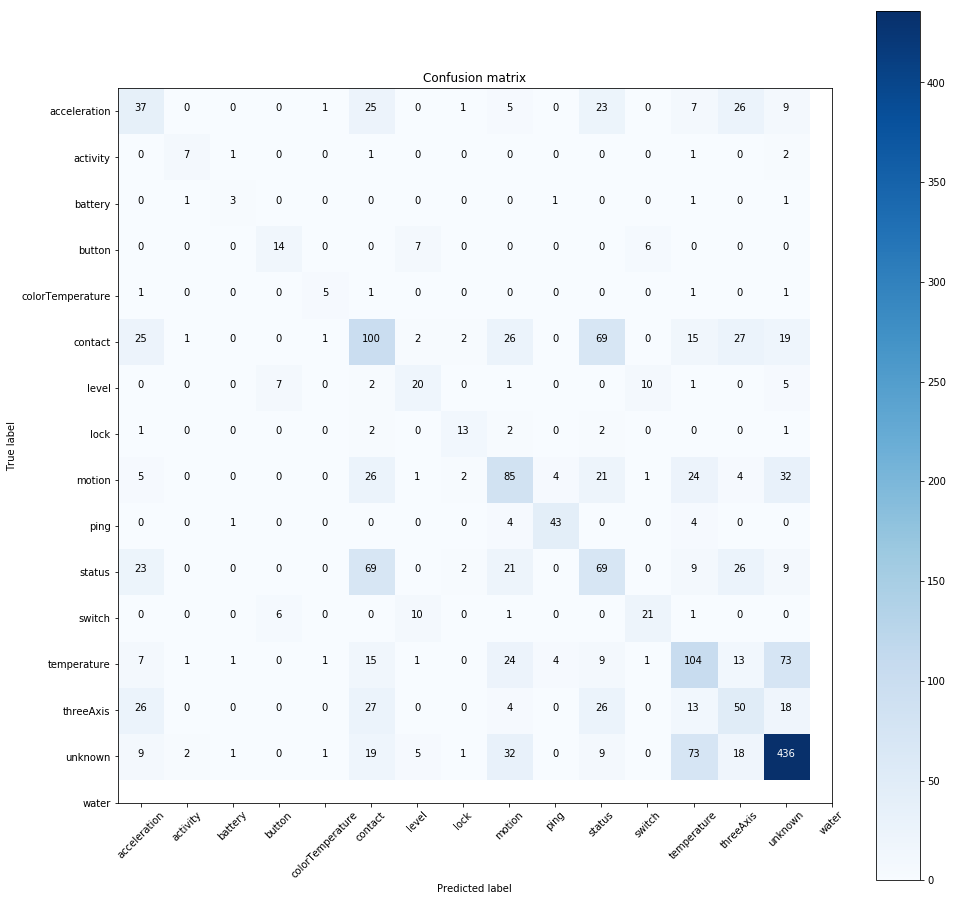

In [93]:
out = calculate_collision( x_test[1], make_readable_results(  fix_unknwons(lstm_tests[i][1], 14),classes,0.7) ,classes )
plot_confusion_matrix( out.astype(int), classes, normalize=False )

Confusion matrix, without normalization


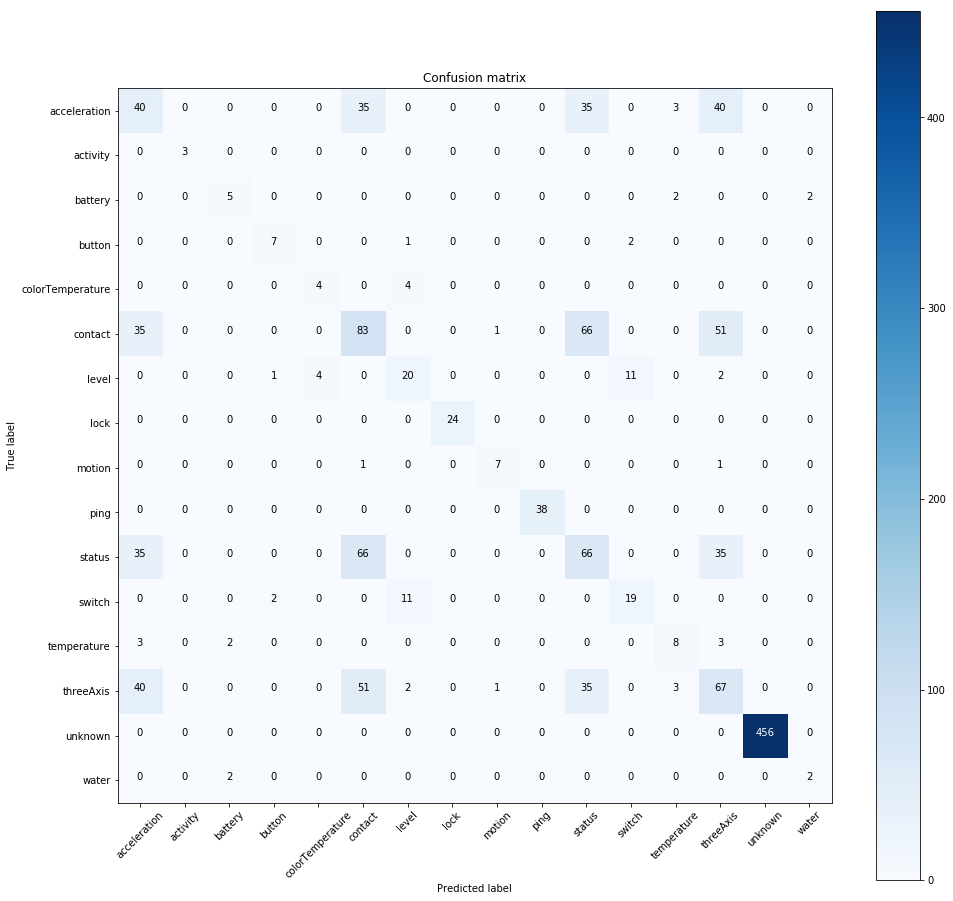

In [92]:
out = calculate_collision( x_test[1], make_readable_results(  fix_unknwons(lstm_pred, 14),classes,0.7) ,classes )
plot_confusion_matrix( out.astype(int), classes, normalize=False )

In [2]:
len(classes)

NameError: name 'classes' is not defined